In [ ]:
#https://medium.com/analytics-vidhya/time-series-forecast-anomaly-detection-with-facebook-prophet-558136be4b8d
#https://grabngoinfo.com/3-ways-for-multiple-time-series-forecasting-using-prophet-in-python/

#Prophet is an open-source library developed by Facebook and designed for automatic forecasting of univariate time series data.

In [ ]:
# %pip install altair vega_datasets

In [1]:
import glob #glob module provides a function for making file lists from directory wildcard searches 
import os #Imports the OS interface module

#Packages for data processing/wranging
import pandas as pd
import numpy as np

#To visualise data - esp zooming into data points
import plotly.express as px
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime

# Prophet model for time series forecast
from fbprophet import Prophet

# Model performance evaluation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# # Spark
# from pyspark.sql.types import *
# from pyspark.sql.functions import pandas_udf, PandasUDFType

# Multi-processing
from multiprocessing import Pool, cpu_count

# Process bar
from tqdm import tqdm

# Tracking time
from time import time

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import altair as alt
from IPython.display import HTML

In [ ]:
# !conda install -c conda-forge fbprophet -y

In [ ]:
# !pip install --upgrade plotly

In [ ]:
# pip install typing-extensions

In [2]:
tmdata1 = pd.read_csv('fulldf_hourly.csv')
tmdata1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104292 entries, 0 to 104291
Data columns (total 58 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AssetID                104292 non-null  object 
 1   FullDate               104292 non-null  object 
 2   Date                   104292 non-null  object 
 3   Reading_Imp            104292 non-null  float64
 4   Time                   104292 non-null  object 
 5   tempC                  104292 non-null  int64  
 6   windspeedKmph          104292 non-null  int64  
 7   winddirDegree          104292 non-null  int64  
 8   precipMM               104292 non-null  float64
 9   humidity               104292 non-null  int64  
 10  visibility             104292 non-null  int64  
 11  pressure               104292 non-null  int64  
 12  cloudcover             104292 non-null  int64  
 13  HeatIndexC             104292 non-null  int64  
 14  DewPointC              104292 non-nu

In [3]:
tmdata = tmdata1[['AssetID','FullDate','Reading_Imp','tempC','precipMM','humidity','pressure','WindGustKmph','totalSnow_cm','24HrsCumRainfall',
              'winddirDegree', 'visibility', 'cloudcover', 'TempGt20nRain','SGFNTRain']].copy()
# tmdata = tmdata1[['AssetID','FullDate','Reading_Imp']].copy()
tmdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104292 entries, 0 to 104291
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   AssetID           104292 non-null  object 
 1   FullDate          104292 non-null  object 
 2   Reading_Imp       104292 non-null  float64
 3   tempC             104292 non-null  int64  
 4   precipMM          104292 non-null  float64
 5   humidity          104292 non-null  int64  
 6   pressure          104292 non-null  int64  
 7   WindGustKmph      104292 non-null  int64  
 8   totalSnow_cm      104292 non-null  float64
 9   24HrsCumRainfall  104292 non-null  float64
 10  winddirDegree     104292 non-null  int64  
 11  visibility        104292 non-null  int64  
 12  cloudcover        104292 non-null  int64  
 13  TempGt20nRain     104292 non-null  int64  
 14  SGFNTRain         104292 non-null  int64  
dtypes: float64(4), int64(9), object(2)
memory usage: 11.9+ MB


In [4]:
#Facebook Prophet model required the dataframe to have the timeseries index as ds and the timeseries value as y. Hence, renaming
tm_df = tmdata.rename({'FullDate':'ds','Reading_Imp':'y'},axis='columns')
tm_df.head()

,AssetID,ds,y,tempC,precipMM,humidity,pressure,WindGustKmph,totalSnow_cm,24HrsCumRainfall,winddirDegree,visibility,cloudcover,TempGt20nRain,SGFNTRain
0,1E09474,2019-01-01 00:00:00,36.1550,5,0.0,93,1036,17,0.0,0.0,268,10,24,0,0
1,1E09474,2019-01-01 01:00:00,35.8450,5,0.0,93,1036,18,0.0,0.0,271,10,24,0,0
2,1E09474,2019-01-01 02:00:00,37.1800,5,0.0,93,1035,20,0.0,0.0,273,10,24,0,0
3,1E09474,2019-01-01 03:00:00,29.7100,5,0.0,93,1035,22,0.0,0.0,276,10,24,0,0
4,1E09474,2019-01-01 04:00:00,34.9025,5,0.0,93,1035,22,0.0,0.0,278,10,24,0,0


In [5]:
tm_df.ds = pd.to_datetime(tm_df.ds) # properly convert to datetime type
tm_df.index = tm_df.ds # make x-axis naturally appear in the datetime format
# tm_df.y.plot()
# plt.show()

In [ ]:
tm_df.info()

In [6]:
# Group the data by ticker
groups_by_asset = tm_df.groupby('AssetID')
# Check the groups in the dataframe
groups_by_asset.groups.keys()

dict_keys(['1E09474', '1E18034', '3E03007', '3E43383'])

In [7]:
asset_list = ['1E09474', '1E18034', '3E03007', '3E43383']

In [ ]:
#Define function
#Prophet() initiates the time series model with the default hyperparameters, and we give the model the name m

def train_and_forecast(group):
  # Initiate the model
    m = Prophet(changepoint_range=0.95)
  
  # Fit the model
    m = m.fit(group)
  # Make predictions
#   future = m.make_future_dataframe(periods=15)
    forecast = m.predict(group)
    forecast['fact'] = group['y'].reset_index(drop = True)
    forecast['precipMM'] = group['precipMM'].reset_index(drop = True)
    forecast['AssetID'] = group['AssetID'].iloc[0]
    
#     return forecast[['AssetID','ds','yhat','trend','yhat_upper', 'yhat_lower','fact']]
    return forecast

#   forecast = m.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    
  # Return the forecasted results
#   return forecast[['AssetID','ds','yhat', 'yhat_upper', 'yhat_lower']]  

In [ ]:
# train_and_forecast(tm_df)

In [ ]:
# tm_train_and_forecast = train_and_forecast(tm_df)
# tm_train_and_forecast

In [22]:
def detect_anomalies(forecast):
    forecasted = forecast[['AssetID','ds','yhat','trend','yhat_lower','yhat_upper','fact','precipMM']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

# pred = detect_anomalies(pred)

In [20]:
def plot_anomalies2(forecasted):
#     plt.figure(figsize=(15, 18))
    fig, ax1 = plt.subplots(figsize=(25, 18))
    ax2 = ax1.twinx()
    ax1.set_title("Telemtry Readings and Rainfall")

    a = forecasted.loc[(forecasted['anomaly'] == 1) | (forecasted['anomaly'] == -1)] #anomaly
    ax1.scatter(forecasted['ds'], forecasted['fact'], label="Normal")
    ax1.scatter(a['ds'], a['fact'], color='red', label="Anomaly")
#     plt.plot(modeldata['FullDate'], modeldata['precipMM'], color='lime')

    ax1.set_ylabel('Telemetry Readings')
    ax2.set_ylabel('Rainfall in mm')
    ax2.plot(forecasted['ds'], forecasted['precipMM'], color='lime', label="Rainfall in mm")
    ax1.legend()
    ax2.legend(loc=2)
    plt.show()

In [ ]:
# Start time
start_time = time()
# Create an empty dataframe
for_loop_forecast = pd.DataFrame()
# Loop through each ticker
for asset in asset_list:
    # Get the data for the ticker
    group = groups_by_asset.get_group(asset)  
    # Make forecast
    forecast = train_and_forecast(group)
    forecasted = detect_anomalies(forecast)
    # Add the forecast results to the dataframe
    for_loop_forecast = pd.concat((for_loop_forecast, forecasted)) #earlier it was 'forecast'
#     pred = detect_anomalies(group)
    plot_anomalies2(forecasted)
        
print('The time used for the for-loop forecast is ', time()-start_time)
# Take a look at the data
for_loop_forecast.head()

In [ ]:
for_loop_forecast['anomaly'].value_counts()

In [ ]:
for_loop_forecast.info()

In [ ]:
for_loop_forecast

In [ ]:
plot_anomalies(forecasted.head(5000))

In [ ]:
forecasted.shape

In [ ]:
for_loop_forecast['AssetID'].value_counts()

In [ ]:
# Writing the data to a csv file =
for_loop_forecast.to_csv("modeloutputcheck.csv", index=False)

In [18]:
#Define function
#Prophet() initiates the time series model with the default hyperparameters, and we give the model the name m

def train_and_forecast2(group):
  # Initiate the model
    m = Prophet(changepoint_prior_scale=0.01)
#     changepoint_range=0.95
    m.add_regressor('tempC')
    m.add_regressor('precipMM')
    m.add_regressor('humidity')
    m.add_regressor('pressure')
    m.add_regressor('WindGustKmph')
    m.add_regressor('totalSnow_cm')
    m.add_regressor('24HrsCumRainfall')
    m.add_regressor('winddirDegree')
    m.add_regressor('visibility')
    m.add_regressor('cloudcover')
    m.add_regressor('TempGt20nRain')
    m.add_regressor('SGFNTRain')
    m.add_country_holidays(country_name='UK')
  # Fit the model
    m = m.fit(group)
  # Make predictions
#   future = m.make_future_dataframe(periods=15)
    forecast = m.predict(group)
    forecast['fact'] = group['y'].reset_index(drop = True)
    forecast['AssetID'] = group['AssetID'].iloc[0]
    
#     return forecast[['AssetID','ds','yhat','trend','yhat_upper', 'yhat_lower','fact']]
    return forecast

#   forecast = m.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    
  # Return the forecasted results
#   return forecast[['AssetID','ds','yhat', 'yhat_upper', 'yhat_lower']]  

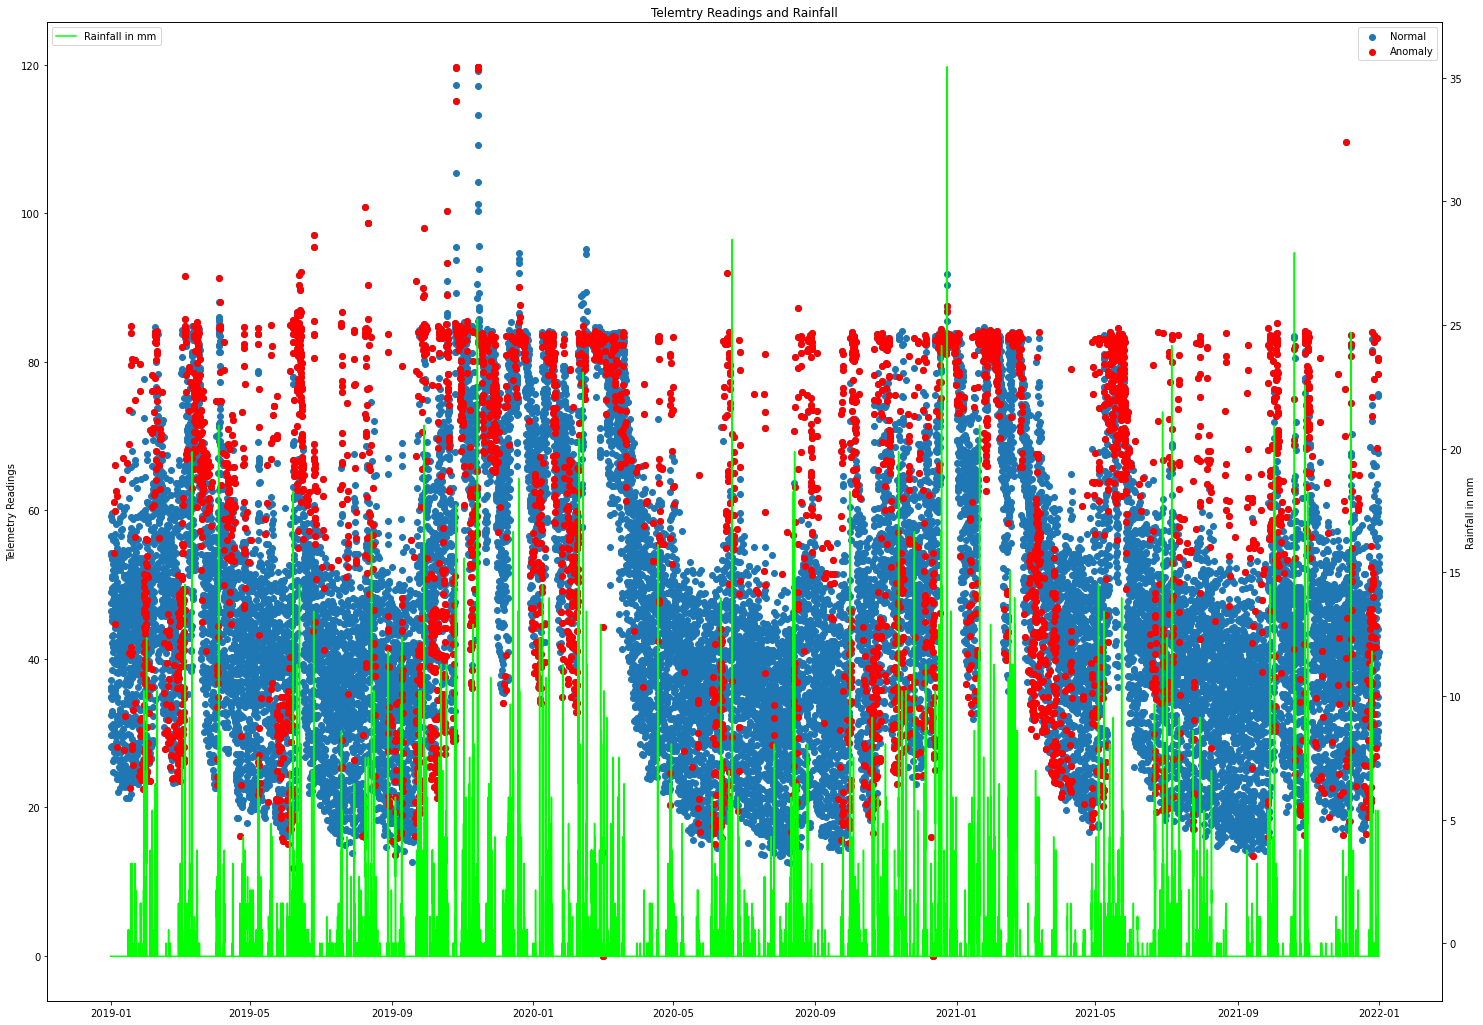

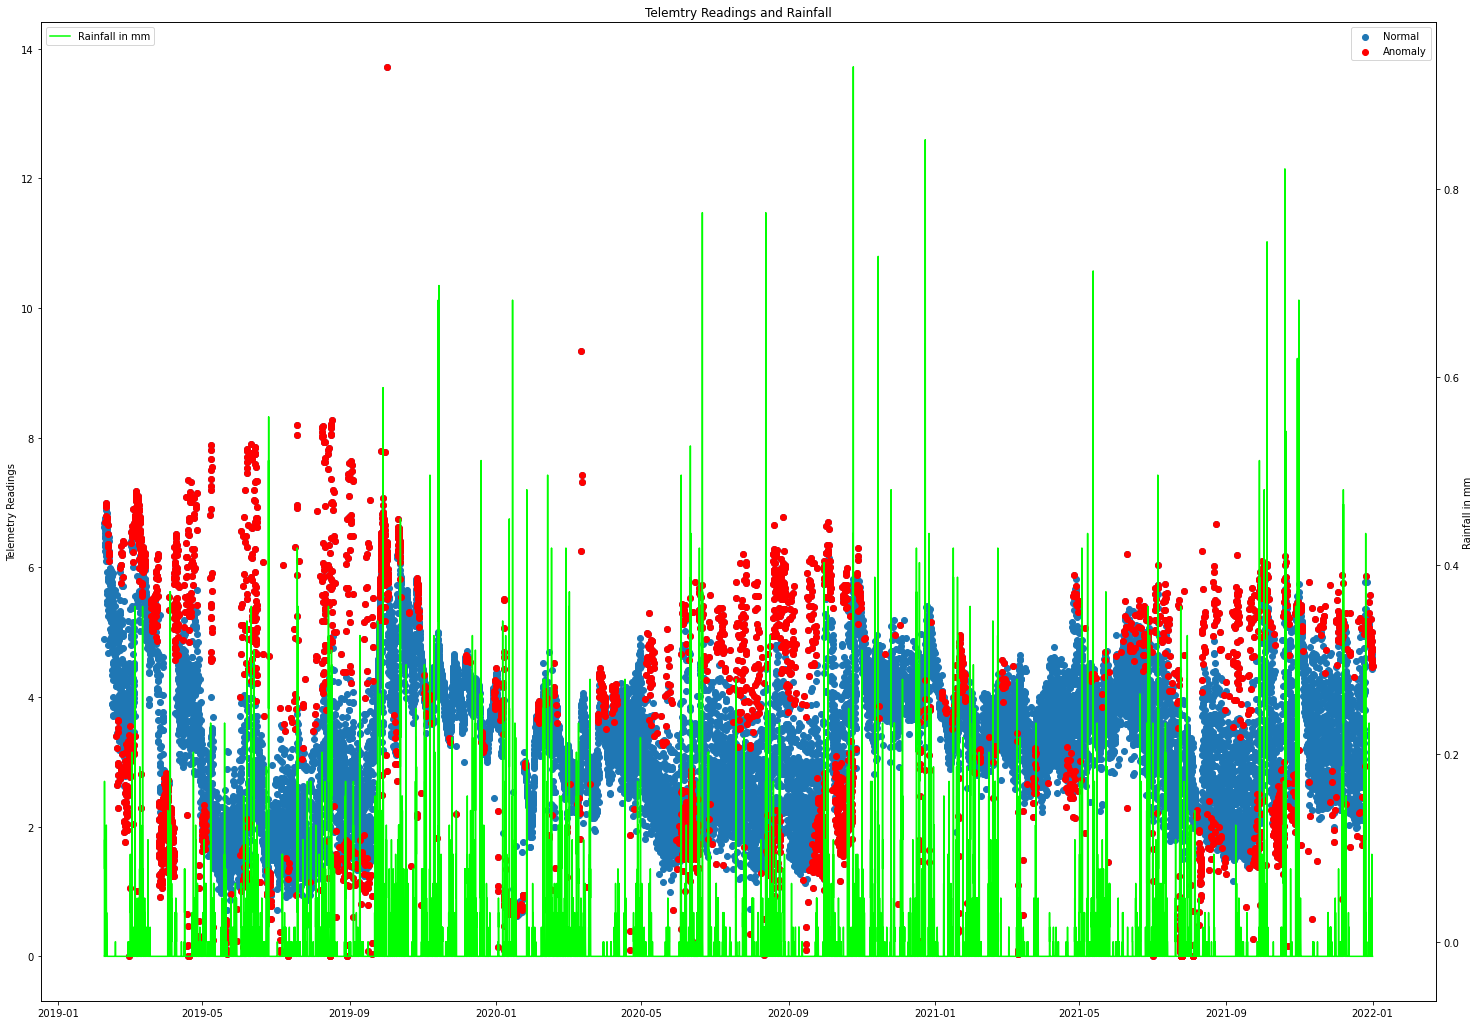

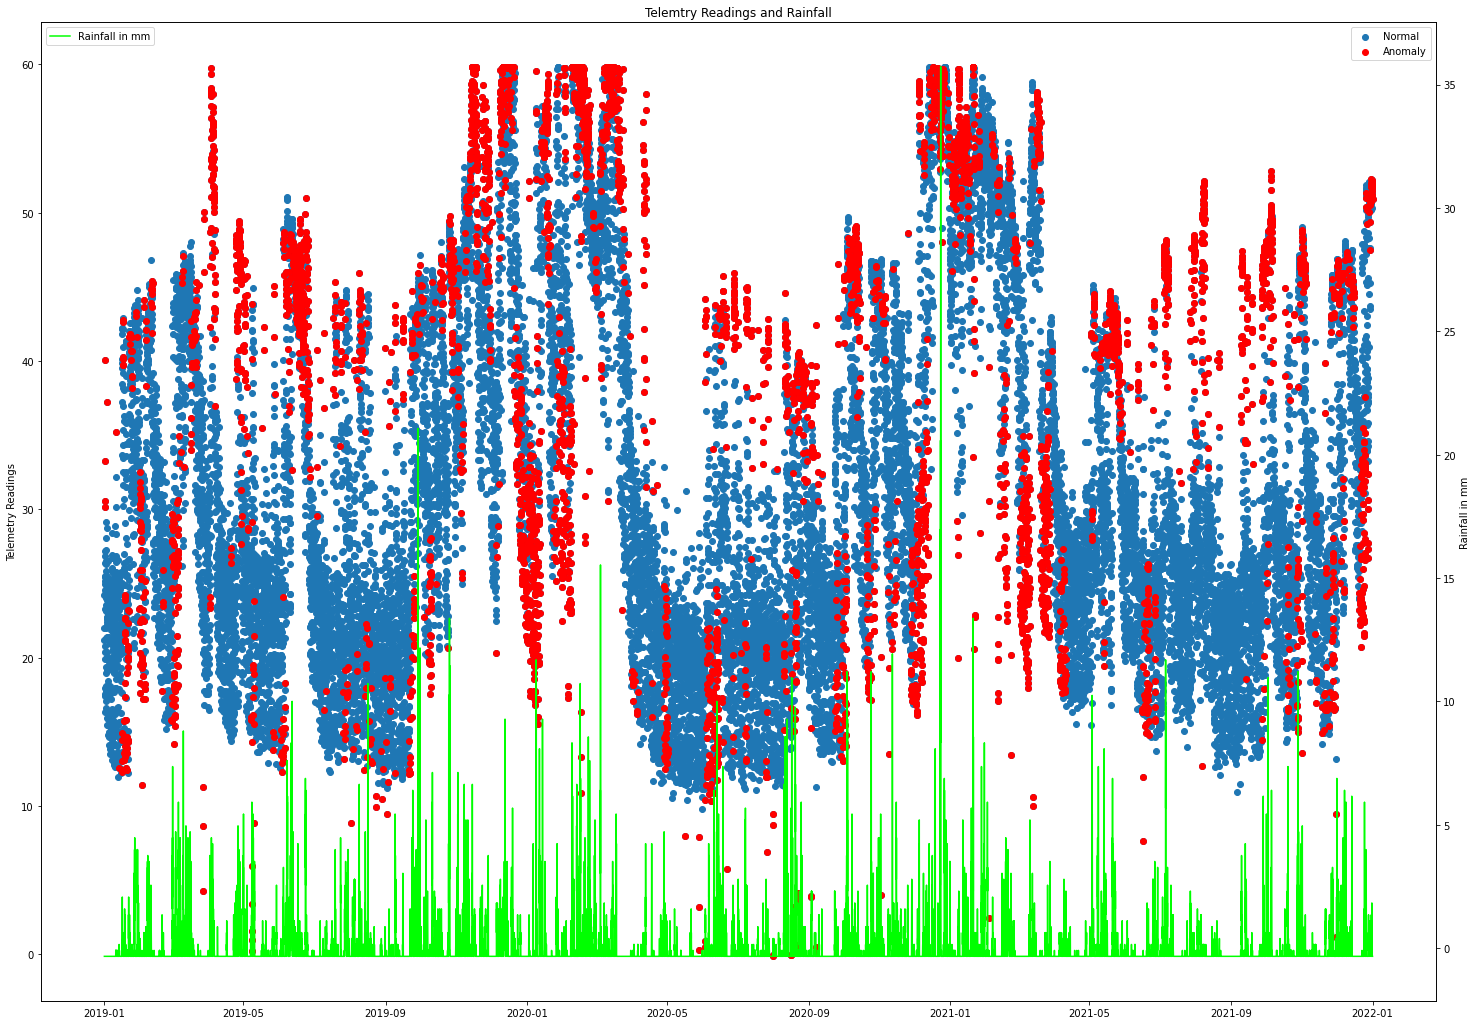

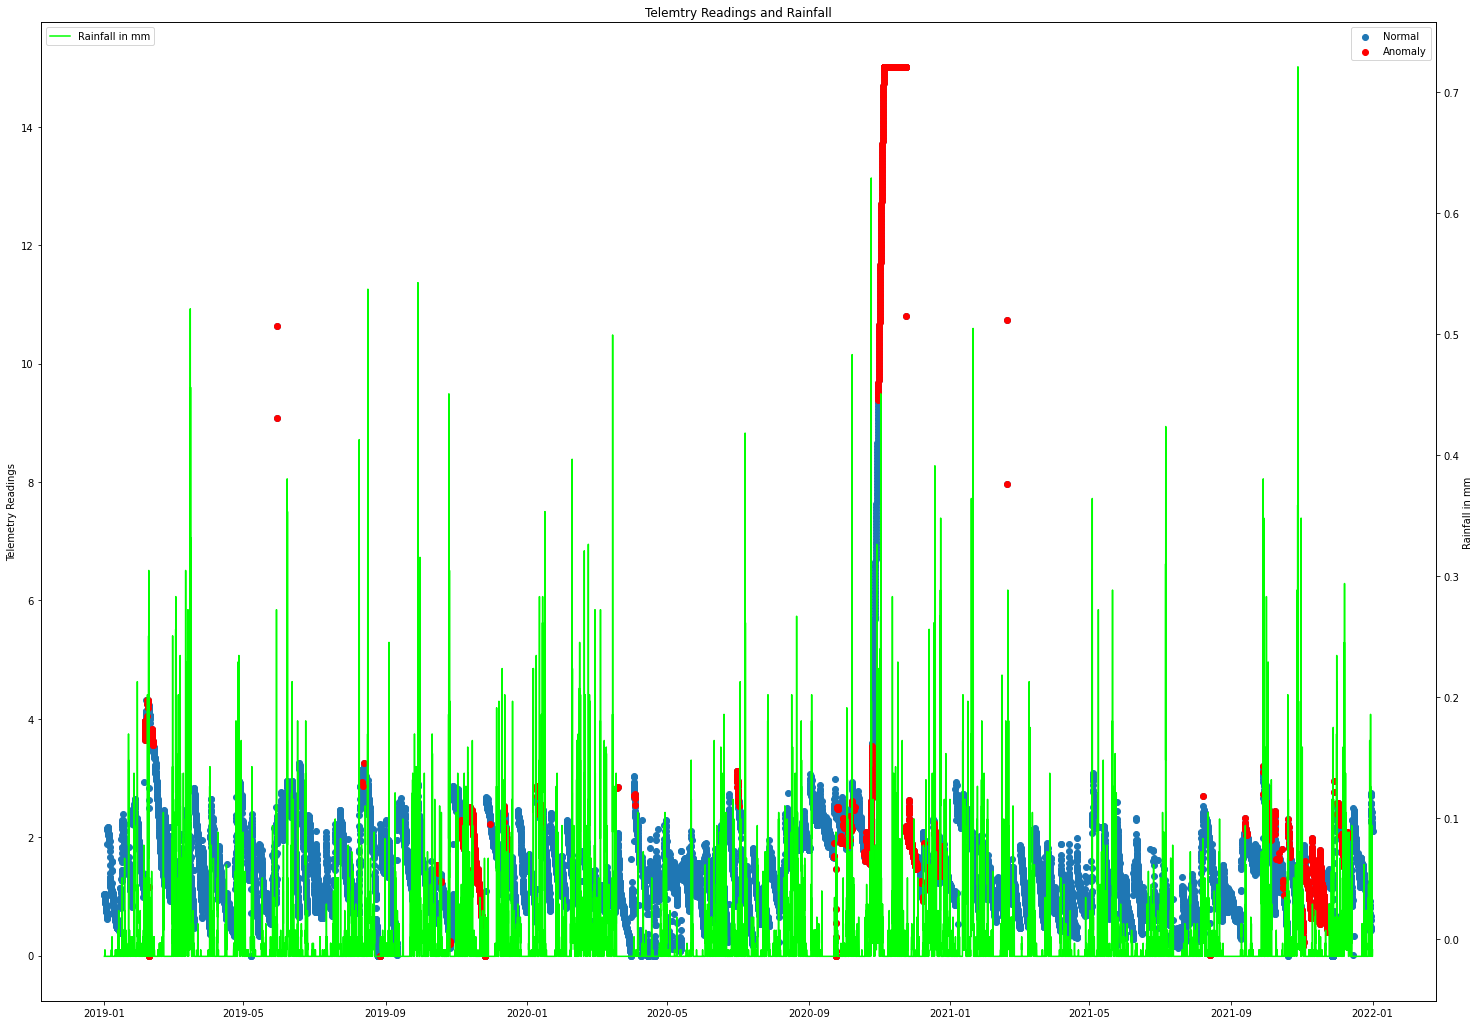

The time used for the for-loop forecast is  732.1386570930481


,AssetID,ds,yhat,trend,yhat_lower,yhat_upper,fact,precipMM,anomaly,importance
0,1E09474,2019-01-01 00:00:00,32.134883,31.541021,18.578144,46.158875,36.1550,-0.518493,0,0.0
1,1E09474,2019-01-01 01:00:00,29.843323,31.548186,16.155732,43.843136,35.8450,-0.518493,0,0.0
2,1E09474,2019-01-01 02:00:00,28.117116,31.555351,15.072883,42.212729,37.1800,-0.518493,0,0.0
3,1E09474,2019-01-01 03:00:00,26.480340,31.562517,13.130641,39.573341,29.7100,-0.518493,0,0.0
4,1E09474,2019-01-01 04:00:00,26.318478,31.569682,12.481321,40.401880,34.9025,-0.518493,0,0.0


In [23]:
# Start time
start_time = time()
# Create an empty dataframe
for_loop_forecast2 = pd.DataFrame()
# Loop through each ticker
for asset in asset_list:
    # Get the data for the ticker
    group = groups_by_asset.get_group(asset)  
    # Make forecast
    forecast = train_and_forecast2(group)
    forecasted = detect_anomalies(forecast)
    # Add the forecast results to the dataframe
    for_loop_forecast2 = pd.concat((for_loop_forecast2, forecasted)) #earlier it was 'forecast'
#     pred = detect_anomalies(group)
    plot_anomalies2(forecasted)
        
print('The time used for the for-loop forecast is ', time()-start_time)
# Take a look at the data
for_loop_forecast2.head()

In [ ]:
for_loop_forecast2.info()

In [12]:
# Writing the data to a csv file =
for_loop_forecast2.to_csv("fbprophetaftertuning.csv", index=False)

##### Try later..

In [ ]:
#Cross validation and Tuning
#https://facebook.github.io/prophet/docs/diagnostics.html
#https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3

In [ ]:
#Seasonality, holiday effects and regressors
#https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html